In [0]:
!pip install keras_sequential_ascii

import numpy as np

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.core import Reshape
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.utils import plot_model
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import metrics

from sklearn.utils import shuffle

import random

Using TensorFlow backend.


In [0]:
# Connecting gDrive to gColab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Dataset variables
num_train = 60000
num_test = 15000
num_val = 15000

In [0]:
# Copying data files to Colab
!cp "/content/gdrive/My Drive/PPSSP/data/DblDifr.txt" "dbl.txt"
!cp "/content/gdrive/My Drive/PPSSP/data/SinDifr.txt" "sin.txt"
!cp "/content/gdrive/My Drive/PPSSP/data/MinBias.txt" "bg.txt"

In [0]:
# Reading files into list array
with open("dbl.txt") as dbl:
  pythia_dbl = [line.split() for line in dbl]

pythia_dbl = np.array(pythia_dbl)

with open("sin.txt") as sin:
  pythia_sin = [line.split() for line in sin]

pythia_sin = np.array(pythia_sin)

with open("bg.txt") as bg:
  pythia_bg = [line.split() for line in bg]
  
pythia_bg = np.array(pythia_bg)

In [0]:
# Filling tag arrays
pythia_dbl_tag = np.full((pythia_dbl.shape[0], 1), 2)
pythia_sin_tag = np.full((pythia_sin.shape[0], 1), 1)
pythia_bg_tag = np.full((pythia_bg.shape[0], 1), 0)

In [0]:
# Mering datasets
pythia = np.concatenate((pythia_dbl, pythia_sin, pythia_bg), axis = 0) 
pythia_tag = np.concatenate((pythia_dbl_tag, pythia_sin_tag, pythia_bg_tag), axis = 0)

In [0]:
# Rapidity gap algorithm
# This one takes the lowest distance of a particle from the middle
def process(data):
  out = np.empty((data.shape[0], 3))
  for i in range(data.shape[0]):
    # Central gap
    min_c = 1.0
    tmp = data[i]
    cut = tmp[1::3]
    cut = sorted(cut, key = float)
    for j in range(len(cut)-1):
      dist_c = abs(float(cut[j]))
      if dist_c < min_c:
        min_c = dist_c
    # Left gap
    min_l = abs(-1.0 - float(cut[0]))
    
    # Right gap
    min_r = abs(1.0 - float(cut[len(cut)-1]))
    
    out[i,0] = np.array(min_c)
    out[i,1] = np.array(min_l)
    out[i,2] = np.array(min_r)
  return out

In [0]:
# Rapidity gap algorithm
# This one takes the largest gap between neighbouring particles
'''
def process(data):
  out = np.empty((data.shape[0], 3))
  for i in range(data.shape[0]):
    # Central gap
    max_c = 0.0
    tmp = data[i]
    cut = tmp[1::3]
    cut = sorted(cut, key = float)
    for j in range(len(cut)-1):
      dist_c = abs(float(cut[j]) - float(cut[j+1]))
      if dist_c > max_c:
        max_c = dist_c
    # Left gap
    min_l = abs(-1.0 - float(cut[0]))
    
    # Right gap
    min_r = abs(1.0 - float(cut[len(cut)-1]))
    
    out[i,0] = np.array(max_c)
    out[i,1] = np.array(min_l)
    out[i,2] = np.array(min_r)
  return out
'''

'\ndef process(data):\n  out = np.empty((data.shape[0], 3))\n  for i in range(data.shape[0]):\n    # Central gap\n    max_c = 0.0\n    tmp = data[i]\n    cut = tmp[1::3]\n    cut = sorted(cut, key = float)\n    for j in range(len(cut)-1):\n      dist_c = abs(float(cut[j]) - float(cut[j+1]))\n      if dist_c > max_c:\n        max_c = dist_c\n    # Left gap\n    min_l = abs(-1.0 - float(cut[0]))\n    \n    # Right gap\n    min_r = abs(1.0 - float(cut[len(cut)-1]))\n    \n    out[i,0] = np.array(max_c)\n    out[i,1] = np.array(min_l)\n    out[i,2] = np.array(min_r)\n  return out\n'

In [0]:
# Processing data
pythia_processed = process(pythia)

In [0]:
# Shuffling data
pythia_processed, pythia_tag = shuffle(pythia_processed, pythia_tag)

In [0]:
# Temporary variables for data sorting
num_fit = num_train + num_test
num_total = num_train + num_test + num_val

In [0]:
# Data sorting
xx_train_pythia = pythia_processed[0:num_train]
xx_test_pythia = pythia_processed[num_train:num_fit]
xx_val_pythia = pythia_processed[num_fit:num_total]

yy_train_pythia = pythia_tag[0:num_train]
yy_test_pythia= pythia_tag[num_train:num_fit]
yy_val_pythia = pythia_tag[num_fit:num_total]

yy_train_pythia = np_utils.to_categorical(yy_train_pythia, 3)
yy_test_pythia = np_utils.to_categorical(yy_test_pythia, 3)
yy_val_pythia = np_utils.to_categorical(yy_val_pythia, 3)

In [0]:
# Model variables
batch_size = 32
epochs = 64

# Used dataset
# relic form when the code had multiple datasets
xx_train = xx_train_pythia
xx_test = xx_test_pythia
xx_val = xx_val_pythia

yy_train = yy_train_pythia
yy_test = yy_test_pythia
yy_val = yy_val_pythia

In [0]:
# Define Model
def base_model():
  model = Sequential()
  
  model.add(Reshape((xx_train.shape[1], 1), input_shape=(xx_train.shape[1], )))  
  
  model.add(Dense(128, activation = 'relu'))
  model.add(Dropout(rate = 0.2))

  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(rate = 0.2))

  model.add(Dense(32, activation = 'relu'))
  model.add(Dropout(rate = 0.2))

  model.add(Dense(16, activation = 'relu'))
  model.add(Dropout(rate = 0.3))

  model.add(Flatten())

  model.add(Dense(3, activation = 'softmax'))
  
# Train model
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [metrics.categorical_accuracy]) 
  return model

In [0]:
# Vizualizing model structure
# Model summary (ascii)
cnn_n = base_model()
cnn_n.summary()

# Model printout (ascii)
# sequential_model_to_ascii_printout(cnn_n)

# Plotting model in graphical mode
plot_model(cnn_n)   ###, to_file='model.png')  ###, show_shapes=True

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_16 (Reshape)         (None, 3, 1)              0         
_________________________________________________________________
dense_76 (Dense)             (None, 3, 128)            256       
_________________________________________________________________
dropout_61 (Dropout)         (None, 3, 128)            0         
_________________________________________________________________
dense_77 (Dense)             (None, 3, 64)             8256      
_________________________________________________________________
dropout_62 (Dropout)         (None, 3, 64)             0         
_________________________________________________________________
dense_78 (Dense)             (None, 3, 32)             2080      
_________________________________________________________________
dropout_63 (Dropout)         (None, 3, 32)             0         
__________

In [0]:
# Patient early stopping
es = EarlyStopping(monitor = 'val_categorical_accuracy', mode = 'max', verbose = 1, patience = 5)
mc = ModelCheckpoint('best_model_conventional_3.h5', monitor = 'val_categorical_accuracy', mode = 'max', verbose = 1, save_best_only = True)

# Fitting model
cnn = cnn_n.fit(xx_train, yy_train, batch_size = batch_size, epochs = epochs, validation_data = (xx_test, yy_test), shuffle = True, callbacks = [es, mc])

# Loading the saved model
saved_model = load_model('best_model_conventional_3.h5')


Train on 60000 samples, validate on 15000 samples
Epoch 1/64
60000/60000 [==============================] - 14s 235us/step - loss: 1.0464 - categorical_accuracy: 0.4417 - val_loss: 1.0358 - val_categorical_accuracy: 0.4497

Epoch 00001: val_categorical_accuracy improved from -inf to 0.44973, saving model to best_model_conventional_3.h5
Epoch 2/64
60000/60000 [==============================] - 9s 142us/step - loss: 1.0374 - categorical_accuracy: 0.4520 - val_loss: 1.0358 - val_categorical_accuracy: 0.4558

Epoch 00002: val_categorical_accuracy improved from 0.44973 to 0.45580, saving model to best_model_conventional_3.h5
Epoch 3/64
60000/60000 [==============================] - 9s 146us/step - loss: 1.0377 - categorical_accuracy: 0.4520 - val_loss: 1.0317 - val_categorical_accuracy: 0.4530

Epoch 00003: val_categorical_accuracy did not improve from 0.45580
Epoch 4/64
60000/60000 [==============================] - 8s 133us/step - loss: 1.0370 - categorical_accuracy: 0.4532 - val_loss: 1.

In [0]:
# Evaluating loaded model
scores_train = saved_model.evaluate(xx_train, yy_train, verbose = 0)
scores_test  = saved_model.evaluate(xx_test, yy_test, verbose = 0)
scores_val   = saved_model.evaluate(xx_val, yy_val, verbose = 0)
print("Accuracy: Train: %.2f%%, Test: %.2f%%, Val: %.2f%% " % (scores_train[1]*100, scores_test[1]*100, scores_val[1]*100))

Accuracy: Train: 45.68%, Test: 45.83%, Val: 45.80% 


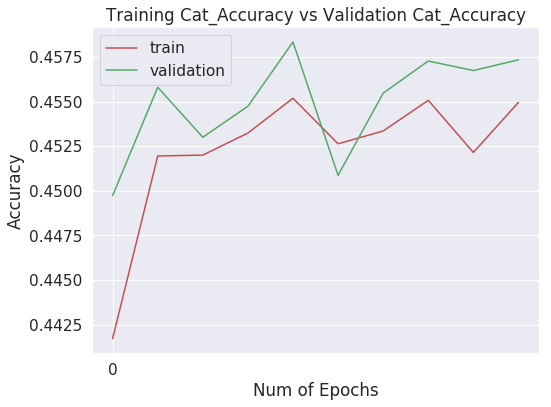

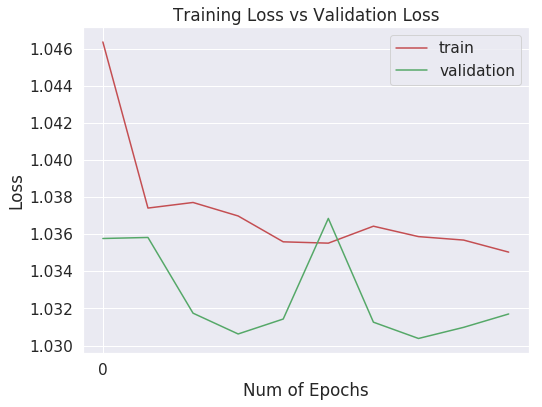

In [0]:
# Plots for training and testing process: loss and accuracy
n_epochs = len(cnn.history['loss'])

plt.figure(0)
plt.plot(cnn.history['categorical_accuracy'],'r')
plt.plot(cnn.history['val_categorical_accuracy'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Cat_Accuracy vs Validation Cat_Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

15000/15000 [==============================] - 2s 149us/step
[[3491  806  715]
 [2065 1092 1747]
 [1660 1137 2287]]


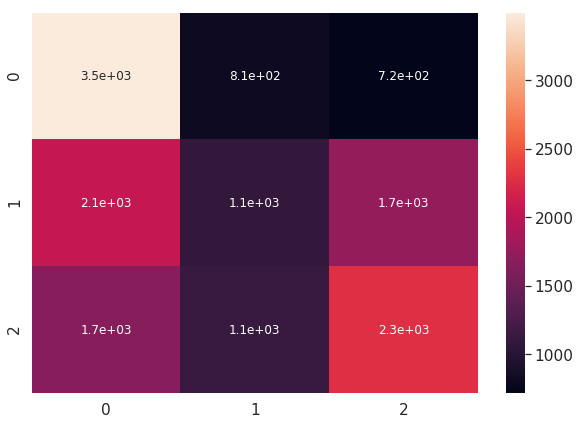

In [0]:
# Confusion matrix result
from sklearn.metrics import classification_report, confusion_matrix
YY_pred = saved_model.predict(xx_val, num_val, verbose=1)
yy_pred = np.argmax(YY_pred, axis=1)

yy_test2 = np.argmax(yy_test, axis=1)

# Confusion matrix
cm = confusion_matrix(np.argmax(yy_val,axis=1),yy_pred)
print(cm)

# Visualizing confusion matrix
import seaborn as sn
import pandas  as pd

df_cm = pd.DataFrame(cm, range(3), range(3))
plt.figure(figsize = (10,7))
sn.set(font_scale = 1.4)#for label size
sn.heatmap(df_cm, annot = True, annot_kws = {"size": 12})# font size
plt.show()